# Αναγνώριση Προτύπων - Μηχανική Μάθηση 3η Εργασία
## Στειροπούλου Ευαγγελία 
### 1115201800186

# FeedForward Neural Network

In [42]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install -U scikit-learn
!pip install torchmetrics

import os
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load mfccs Data 

In [43]:
# path = os.getcwd()
# print(path)

path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/mfccs'
test_data_path = path + '/data/music_genre_data_di/test/mfccs'
validation_data_path = path + '/data/music_genre_data_di/val/mfccs'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

# Μετατροπή των labels σε ακέραιους αριθμούς (0, 1, 2, 3)
classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

# Δημιουργία των Tensor αντικειμένων από τα numpy arrays
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


torch.Size([3200, 26])
torch.Size([3200])
torch.Size([800, 26])
torch.Size([800])
torch.Size([1376, 26])
torch.Size([1376])


## Build Neural Network

In [44]:
class FullyConnectedNeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(FullyConnectedNeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26 , 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cpu"
model = FullyConnectedNeuralNetwork().to(device)
print(model)

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


## Set Neural Network training function

In [45]:
def train_network(model, optimizer, dataloader, loss_function, num_epochs):
    size = len(dataloader.dataset)
    print("size = ", size)

    for epoch in range(num_epochs):
        loss = 0.0
        print("Epoch: ", epoch+1)
        for batch_idx, (data, targets) in enumerate(dataloader):
            #print("batch_idx = ", batch_idx)
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            # Clear the gradients and compute new gradients (backward pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Update the weights

            if batch_idx % 64 == 0:
                loss, current = loss.item(), batch_idx * len(data)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    print('Training finished.')
    return model

## Set evaluation function

In [46]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Put the model in evaluation mode
    device = next(model.parameters()).device

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())


    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

## Train Neural Network

In [48]:
import torch.optim as optim
# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy*100} %")
print("Confusion Matrix:")
print(confusion_mat)
print("Device is ", device)

# Return the trained model
trained_model = model

size =  3200
Epoch:  1
loss: 1.371150  [    0/ 3200]
loss: 1.422054  [ 1024/ 3200]
loss: 1.374104  [ 2048/ 3200]
loss: 1.375402  [ 3072/ 3200]
Epoch:  2
loss: 1.370325  [    0/ 3200]
loss: 1.358170  [ 1024/ 3200]
loss: 1.386380  [ 2048/ 3200]
loss: 1.389071  [ 3072/ 3200]
Epoch:  3
loss: 1.371946  [    0/ 3200]
loss: 1.363304  [ 1024/ 3200]
loss: 1.378773  [ 2048/ 3200]
loss: 1.361656  [ 3072/ 3200]
Epoch:  4
loss: 1.373313  [    0/ 3200]
loss: 1.363847  [ 1024/ 3200]
loss: 1.383338  [ 2048/ 3200]
loss: 1.374541  [ 3072/ 3200]
Epoch:  5
loss: 1.365633  [    0/ 3200]
loss: 1.341108  [ 1024/ 3200]
loss: 1.368165  [ 2048/ 3200]
loss: 1.354001  [ 3072/ 3200]
Epoch:  6
loss: 1.410485  [    0/ 3200]
loss: 1.365477  [ 1024/ 3200]
loss: 1.315250  [ 2048/ 3200]
loss: 1.337621  [ 3072/ 3200]
Epoch:  7
loss: 1.368094  [    0/ 3200]
loss: 1.332011  [ 1024/ 3200]
loss: 1.363492  [ 2048/ 3200]
loss: 1.345203  [ 3072/ 3200]
Epoch:  8
loss: 1.338973  [    0/ 3200]
loss: 1.338615  [ 1024/ 3200]
loss: 1

## Train Network with GPU

In [49]:
import torch.optim as optim
# if we want to utilize the GPU (if available), we need to assign the model to the correct device

if torch.cuda.is_available():
    device="cuda"
    print("GPU available")
else:
    device="cpu"

print ("device=",device)
model = FullyConnectedNeuralNetwork().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)

# Return the trained model
trained_model = model

GPU available
device= cuda
size =  3200
Epoch:  1
loss: 1.517304  [    0/ 3200]
loss: 1.386739  [ 1024/ 3200]
loss: 1.367908  [ 2048/ 3200]
loss: 1.376221  [ 3072/ 3200]
Epoch:  2
loss: 1.368696  [    0/ 3200]
loss: 1.360155  [ 1024/ 3200]
loss: 1.333066  [ 2048/ 3200]
loss: 1.355017  [ 3072/ 3200]
Epoch:  3
loss: 1.358517  [    0/ 3200]
loss: 1.347243  [ 1024/ 3200]
loss: 1.368435  [ 2048/ 3200]
loss: 1.358649  [ 3072/ 3200]
Epoch:  4
loss: 1.378953  [    0/ 3200]
loss: 1.323637  [ 1024/ 3200]
loss: 1.336869  [ 2048/ 3200]
loss: 1.373019  [ 3072/ 3200]
Epoch:  5
loss: 1.330064  [    0/ 3200]
loss: 1.334543  [ 1024/ 3200]
loss: 1.342722  [ 2048/ 3200]
loss: 1.381530  [ 3072/ 3200]
Epoch:  6
loss: 1.341136  [    0/ 3200]
loss: 1.338463  [ 1024/ 3200]
loss: 1.330008  [ 2048/ 3200]
loss: 1.333632  [ 3072/ 3200]
Epoch:  7
loss: 1.289046  [    0/ 3200]
loss: 1.325701  [ 1024/ 3200]
loss: 1.337502  [ 2048/ 3200]
loss: 1.329291  [ 3072/ 3200]
Epoch:  8
loss: 1.323962  [    0/ 3200]
loss: 1.30

## Choose model

In [50]:
def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function)

        print(f"Epoch: {epoch+1}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("Validation Confusion Matrix:")
        print(val_confusion_mat)

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_model = model
            best_f1 = val_f1

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function)

    print("Best Model Performance on Test Set:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    return best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [51]:
best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs
)

size =  3200
Epoch:  1
loss: 0.879004  [    0/ 3200]
loss: 1.038337  [ 1024/ 3200]
loss: 0.752093  [ 2048/ 3200]
loss: 0.941320  [ 3072/ 3200]
Training finished.
Epoch: 1
Validation Loss: 0.9248
Validation F1: 0.6541
Validation Accuracy: 0.6700
Validation Confusion Matrix:
[[ 61  27  77  35]
 [ 25 157   5  13]
 [ 25   3 155  17]
 [ 10   8  19 163]]
size =  3200
Epoch:  1
loss: 0.817411  [    0/ 3200]
loss: 1.021882  [ 1024/ 3200]
loss: 0.770866  [ 2048/ 3200]
loss: 0.872439  [ 3072/ 3200]
Training finished.
Epoch: 2
Validation Loss: 0.9379
Validation F1: 0.5918
Validation Accuracy: 0.6125
Validation Confusion Matrix:
[[ 52  37  15  96]
 [ 11 158   3  28]
 [ 33   4  97  66]
 [  3  10   4 183]]
size =  3200
Epoch:  1
loss: 0.788146  [    0/ 3200]
loss: 1.145306  [ 1024/ 3200]
loss: 0.732208  [ 2048/ 3200]
loss: 1.108571  [ 3072/ 3200]
Training finished.
Epoch: 3
Validation Loss: 0.9215
Validation F1: 0.6117
Validation Accuracy: 0.6275
Validation Confusion Matrix:
[[ 52  23  95  30]
 [ 46

# Convolutional Neural Network

## Load spectrograms data

In [52]:
# path = os.getcwd()
# print(path)

path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/melgrams'
test_data_path = path + '/data/music_genre_data_di/test/melgrams'
validation_data_path = path + '/data/music_genre_data_di/val/melgrams'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


torch.Size([3200, 21, 128])
torch.Size([3200])
torch.Size([800, 21, 128])
torch.Size([800])
torch.Size([1376, 21, 128])
torch.Size([1376])


Bellow I will plot a random melgram of each class. I will retrieve the class names from the labels in the dataset.

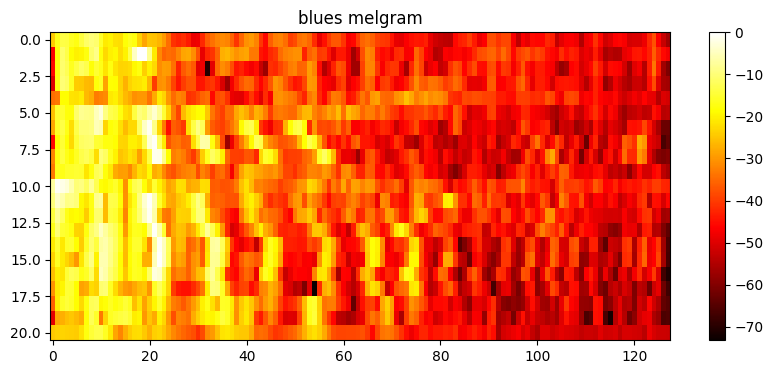

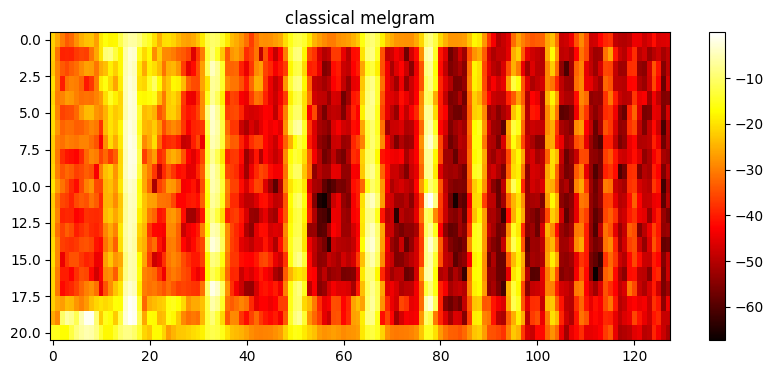

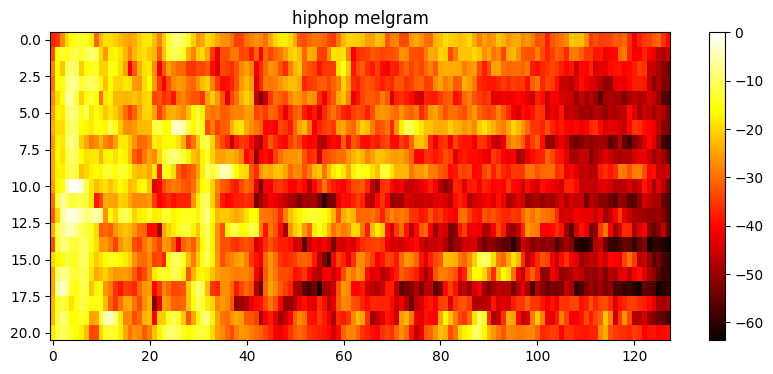

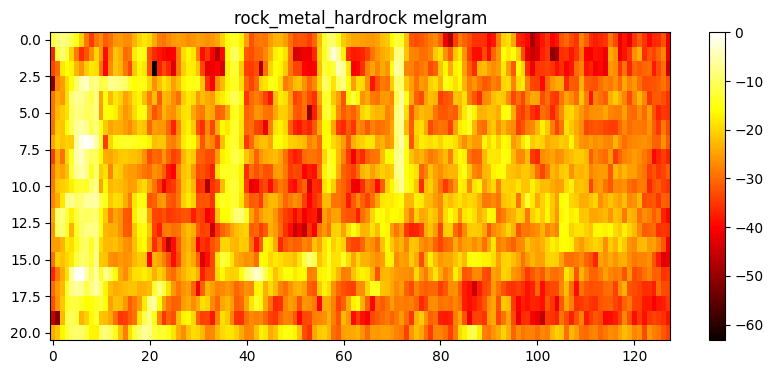

In [53]:
import random

def visualize_melgram(melgram, class_name):
    plt.figure(figsize=(10, 4))
    plt.imshow(melgram, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(class_name + ' melgram')
    plt.show()

# Function to plot a random melgram from each class
def plot_random_melgram_from_each_class(dataset, class_labels, class_names):
    classes = np.unique(class_labels)
    for class_label in classes:
        indices = np.where(class_labels == class_label)[0]
        # Select a random index
        random_index = random.choice(indices)
        melgram, label = dataset[random_index]
        class_name = class_names[class_label]  # Get the class name corresponding to the class label
        visualize_melgram(melgram, class_name)

# Retrieve the class names from the class_to_idx dictionary
class_names = [class_label for class_label, class_index in class_to_idx.items()]

# Plot a random melgram from each class in the training dataset
plot_random_melgram_from_each_class(train_dataset, y_train, class_names)


## Build Neural Network

In [54]:
#set a convolutional neural network with 5 kernels and 4 convolutional layers with sequential 1,16,32,64,128
#and the exit of the last layer to be inserted in a fully connected layer with 5 layers and neurons x(dimensions of the exit of the last convolutional layer), 1024,256,32, out_dim
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.flatten = nn.Flatten()

        # Fully connected stack 5*12*128 = 71680
        self.connected_stack = nn.Sequential(
            nn.Linear(71680, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.connected_stack(x)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet().to(device)
print(model)

ConvolutionalNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (connected_stack): Sequential(
    (0): Linear(in_features=71680, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)


## Train Network

In [55]:
from torchmetrics import F1Score, Accuracy

def train_network(model, optimizer, dataloader, loss_function, num_epochs, device):
    model.train()  # Put the model in training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            optimizer.zero_grad()  # Clear the gradients

            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()  # Update the weights

            running_loss += loss.item()

            if batch_idx % 64 == 99:  # Print the loss every 64 batches
                print(f"Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

def evaluate_model(model, dataloader, loss_function, device):
    model.eval()  # Put the model in evaluation mode

    device = next(model.parameters()).device
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

In [56]:
import copy

def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1, device)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function, device)

        print(f"Epoch: {epoch+1}")
        print("Validation Loss: ", val_loss)
        print("Validation F1: ", val_f1 * 100, "%")
        print("Validation Accuracy: ", val_accuracy* 100 , "%")
        print("Validation Confusion Matrix:")
        print(val_confusion_mat)

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch + 1
            best_model = copy.deepcopy(model)

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function, device)

    print("Best Model Performance on Test Set:")
    print("Test Loss: ", test_loss ,"%")
    print("Test F1: ", test_f1 * 100, "%")
    print("Test Accuracy: ", test_accuracy* 100 , "%")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    print("\nBest F1 macro average score: " ,test_f1 ,"% achieved after ", best_epoch, " epochs.")

    return best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [57]:
# Hyperparameters and Network initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 10

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)
print("\nBest F1 macro average score achieved after ", best_epoch, " epochs.")

Epoch:  1
Epoch: 1
Validation Loss:  nan
Validation F1:  10.0 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch:  2
Epoch: 2
Validation Loss:  nan
Validation F1:  10.0 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch:  3
Epoch: 3
Validation Loss:  nan
Validation F1:  10.0 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch:  4
Epoch: 4
Validation Loss:  nan
Validation F1:  10.0 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch:  5
Epoch: 5
Validation Loss:  nan
Validation F1:  10.0 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]
 [200   0   0   0]]
Epoch

From the results it is clear that the model is unable to train. The loss immediately goes to infinity so it means that the principal features cannot be extracted. I choose to test the results for 10 epochs, to save time, since we we can see from the beginning that the network model is unable to train. The fact that the training is not possible, highlights the need to modify our model, so we will recreate it with padding.

## Set padding to the Convolutional Network

In [58]:
#set convolutional network with padding to 2 and kernel size to 2
import torch.nn.functional as F

class ConvolutionalNet2(nn.Module):
    def __init__(self):
        super(ConvolutionalNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.flatten = nn.Flatten()
        self.connected_stack = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.Linear(1024, 256), 
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2)
        x = self.flatten(x)

        logits = self.connected_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)
print(model)


ConvolutionalNet2(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (connected_stack): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [59]:
# Hyperparameters and Network initialisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)
print("device: ", device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)


device:  cuda:0
Epoch:  1
Epoch: 1
Validation Loss:  1.363681480884552
Validation F1:  36.28255955136074 %
Validation Accuracy:  43.625 %
Validation Confusion Matrix:
[[ 42  29 129   0]
 [ 34 125  41   0]
 [ 15   3 182   0]
 [ 25  13 162   0]]
Epoch:  2
Epoch: 2
Validation Loss:  1.2919226360321046
Validation F1:  24.310122361584487 %
Validation Accuracy:  34.25 %
Validation Confusion Matrix:
[[ 15 165   0  20]
 [  1 196   1   2]
 [ 11 108   1  80]
 [ 33 105   0  62]]
Epoch:  3
Epoch: 3
Validation Loss:  1.1602045238018035
Validation F1:  29.2390289449113 %
Validation Accuracy:  42.25 %
Validation Confusion Matrix:
[[  0  70 130   0]
 [  0 162  37   1]
 [  0  21 176   3]
 [  0  23 177   0]]
Epoch:  4
Epoch: 4
Validation Loss:  1.080539186000824
Validation F1:  48.64183978112827 %
Validation Accuracy:  49.875 %
Validation Confusion Matrix:
[[ 72  74  26  28]
 [ 33 163   2   2]
 [ 39  25  75  61]
 [ 47  18  46  89]]
Epoch:  5
Epoch: 5
Validation Loss:  1.0736162984371185
Validation F1:  

## Optimization Algorithms

First I will define a function that prints the results of the algorithms in a table form, using the Dataframe format from "pandas" module.

In [60]:
import pandas as pd

def print_results_table(results):
    # Create a DataFrame from the results dictionary
    df_results = pd.DataFrame(results).T

    # Rename the columns
    df_results.columns = ['Accuracy', 'F1']

    # Add the algorithm names as a new column
    df_results['Algorithm'] = df_results.index

    # Set the 'Algorithm' column as the index
    df_results.set_index('Algorithm', inplace=True)

    return df_results

Next, I will define a function that selects the best results from the dataframe and prints them.

In [61]:
def best_results(df_results):
    # Find the optimizer with the best accuracy
    best_accuracy_optimizer = df_results['Accuracy'].idxmax()
    best_accuracy = df_results.loc[best_accuracy_optimizer, 'Accuracy']

    # Find the optimizer with the best F1 score
    best_f1_optimizer = df_results['F1'].idxmax()
    best_f1 = df_results.loc[best_f1_optimizer, 'F1']

    # Create a DataFrame for the best results
    best_results_df = pd.DataFrame({
        'Optimizer': [best_accuracy_optimizer, best_f1_optimizer],
        'Accuracy': [best_accuracy, best_f1]
    }, index=['Best Accuracy', 'Best F1 Score'])

    return best_results_df

I will test the Neural Network for the pytorch optimizers bellow, using 30 epochs, learning rate 0.002 and as loss function, the CrossEntropyLoss.

In [62]:
#run all  the optimization algorithms of pytorch and compare the results
import torch.optim as optim

algorithms = {
    'Adadelta': optim.Adadelta,
    'Adagrad': optim.Adagrad,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'Adamax': optim.Adamax,
    'ASGD': optim.ASGD,
    'NAdam': optim.NAdam,
    'RAdam': optim.RAdam,
    'RMSprop': optim.RMSprop,
    'Rprop': optim.Rprop,
    'SGD': optim.SGD
}

loss_function = nn.CrossEntropyLoss()
num_epochs = 30

# Create an empty dictionary to store the results
results = {}

# Hyperparameters and Network initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

for algorithm_name, algorithm_class in algorithms.items():
    print(algorithm_name)
    model = ConvolutionalNet2().to(device)

    # Define the optimizer, learning rate, and loss function
    optimizer = algorithm_class(model.parameters(), lr=0.002)
    print("Optimizer: ", algorithm_name)

    # Train the model and find optimal model
    best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
        model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)

    # Store the results in the dictionary
    results[algorithm_name] = {'accuracy': test_accuracy, 'f1': test_f1}

device:  cuda
Adadelta
Optimizer:  Adadelta
Epoch:  1
Epoch: 1
Validation Loss:  1.3697410678863526
Validation F1:  10.399049356104568 %
Validation Accuracy:  25.0 %
Validation Confusion Matrix:
[[  0 199   1   0]
 [  0 199   1   0]
 [  0 199   1   0]
 [  0 181  19   0]]
Epoch:  2
Epoch: 2
Validation Loss:  1.3483202314376832
Validation F1:  24.247646078298867 %
Validation Accuracy:  34.625 %
Validation Confusion Matrix:
[[  0  12 188   0]
 [  0  78 122   0]
 [  0   1 199   0]
 [  0   3 197   0]]
Epoch:  3
Epoch: 3
Validation Loss:  1.3220197916030885
Validation F1:  29.5112364887826 %
Validation Accuracy:  41.5 %
Validation Confusion Matrix:
[[  0  43 157   0]
 [  0 141  59   0]
 [  0  10 190   0]
 [  0  15 184   1]]
Epoch:  4
Epoch: 4
Validation Loss:  1.273501546382904
Validation F1:  29.660212212542834 %
Validation Accuracy:  42.625 %
Validation Confusion Matrix:
[[  0  63 137   0]
 [  0 159  41   0]
 [  1  17 182   0]
 [  0  18 182   0]]
Epoch:  5
Epoch: 5
Validation Loss:  1.2389

,Optimizer,Accuracy
Best Accuracy,Adamax,0.727471
Best F1 Score,Adamax,0.740121


In [63]:
df_results = print_results_table(results)
# Print the results in a table format
pd.DataFrame(df_results).T

Algorithm,Adadelta,Adagrad,Adam,AdamW,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD
Accuracy,0.628634,0.725291,0.675145,0.650436,0.727471,0.714390,0.682413,0.727471,0.661337,0.642442,0.694041
F1,0.628234,0.733633,0.674741,0.647130,0.740121,0.722227,0.680611,0.732877,0.661046,0.643766,0.694823


Now lets get the best result from the table above.

In [64]:
best_results(df_results)

,Optimizer,Accuracy
Best Accuracy,Adamax,0.727471
Best F1 Score,Adamax,0.740121


As we can see $Adagrad$ has the best accuracy and the best f1 score as well.